In [235]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt

In [236]:
company = input("Choose a company: ")

data = yf.Ticker(company)

Choose a company:  AAPL


In [237]:
hist = data.history(period="max")

closing_price = hist["Close"]

We now consider only part of the data (we exclude the last $N$ days) to get the parameters and then see how our model would perform on future data

In [238]:
N = 7

closing_price_train = closing_price.iloc[:-N]

<Axes: xlabel='Date'>

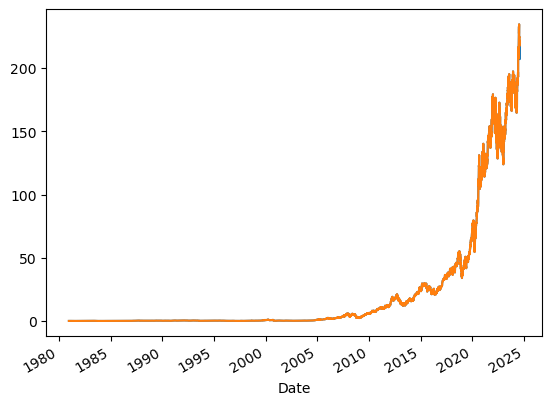

In [239]:
closing_price.plot()
closing_price_train.plot()

# Model
We model the evolution as a *Geometric Brownian Motion (GBM)*.
That is, we assume that 
$$dP(t) = \mu P(t) dt + \sigma dW(t)$$
where $P(t)$ is the price on instant $t$, $\mu$ is the percentage drift, $\sigma$ is the percentage volatility and $W(t)$ is a Wiener process.
This can be solved using Ito's calculus to give
$$
S(t) = S_0 e^{(\mu-\sigma^2/2)t+\sigma W_t}.
$$
Let $d := \mu-\sigma^2/2$.
We thus have incremental quotients of
$$
\frac{S(t)}{S(t-1)} = e^{d+\sigma\epsilon},\quad \epsilon \sim \mathcal{N}(0,1)
$$

We first estimate $d$ by computing the sample average and variance of percentage daily increments. 

In [240]:
variations = 1 + closing_price_train.pct_change()
log_variations = np.log(variations)

mu = np.mean(log_variations)
sigma = np.std(log_variations, ddof=1) #Should I use ddof=1 here? Need to understand this parameter better

d = mu - sigma**2/2

# Prediction

Say we want to predict the price for the next $N$ days. 

We will do a Monte Carlo simulation by evolving n_iter times the process above. 
Hence we need to generate the random variables $\epsilon$.

First we generate random numbers following a normal distribution.
This can be done by generating random numbers uniformly distributed in $(0,1)$ and then computing their $z$-score.

In [241]:
n_iter = 10000

random_uniform = np.random.rand(N, n_iter)
random_normal = norm.ppf(random_uniform)

Now generate vector of random daily percentage variations

In [242]:
daily_variations = d + sigma*random_normal

We start with the latest available price and simulate

In [243]:
p0 = closing_price.iloc[-N]

future_prices = np.zeros_like(daily_variations)
future_prices[0] = p0

for day in range(1,N):
    future_prices[day] = future_prices[day-1] * np.exp(daily_variations[day])

# Plotting

Text(0.5, 1.0, 'Real data')

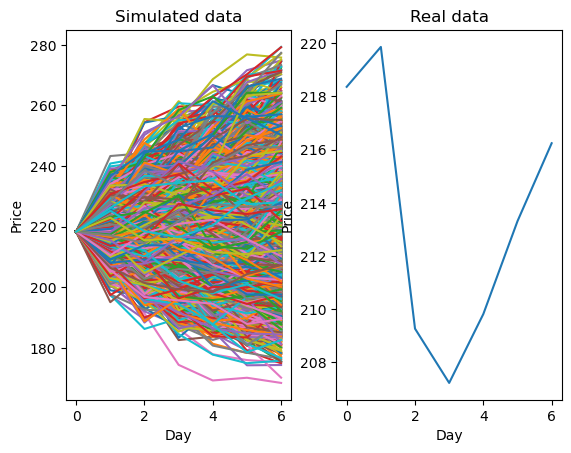

In [244]:
fig, axs = plt.subplots(1,2)

axs[0].plot(future_prices)
axs[0].set_xlabel("Day")
axs[0].set_ylabel("Price")
axs[0].set_title('Simulated data')

axs[1].plot(range(N),closing_price[-N:])
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Price")
axs[1].set_title('Real data')

# Conclusions

To estimate the price after $N$ days, we *average* the predicted price by each model:

In [249]:
final_price = future_prices[-1]
expected_price = np.mean(final_price)
print(f'The expected price after {N} days is {round(expected_price,2)}')

The expected price after 7 days is 219.12


We can also compute a confidence interval for this price:

In [246]:
confidence = input("Input a confidence (%): ")
confidence = float(confidence)/100


expected_price_std = np.std(final_price, ddof=1)

z_score = norm.ppf((1 - confidence)/2)
normal_interval = np.array([z_score,-z_score])
interval = expected_price + expected_price_std/np.sqrt(len(final_price)) * normal_interval

print(f"The predicted price is {round(expected_price,2)}")
print(f"The {confidence*100}% confidence interval is [{round(interval[0],2)},{round(interval[1],2)}]")



Input a confidence (%):  95


The predicted price is 219.12
The 95.0% confidence interval is [218.83,219.42]


# Comparison with real data

In [247]:
real_last_price = closing_price.iloc[-1]

print(f'The real price after {N} days is {round(real_last_price,2)}')
print(f'Your interval was [{round(interval[0],2)},{round(interval[1],2)}]')
if interval[0] < real_last_price and real_last_price < interval[1]:
    print("Real price inside interval")
else:
    print("Real price outside interval")

The real price after 7 days is 216.24
Your interval was [218.83,219.42]
Real price outside interval


<!-- We also plot the data not used for training and the average of the predictions of our model -->
<!-- This does not make sense

In [248]:
# fig, ax = plt.subplots()

# ax.plot(future_prices.mean(axis=1), label="Simulated data")
# ax.plot(range(N),closing_price[-N:], label="Real data")
# ax.set_xlabel("Day")
# ax.set_ylabel("Price")
# ax.legend()